# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color, img_as_ubyte
import os    
import cv2
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
df = pd.DataFrame(columns=['Contrast Feature','Dissimilarity Feature','Homogeneity Feature','Energy Feature','Correlation Feature','ASM Feature'])
B_matrix = []
M_matrix = []

# Image -> Matrix conversion

In [3]:
#Reading the Images

path_of_Benign = r"C:/Users/Madhu mitha/Downloads/Distinguishing Skin Cancer from Skin Rashes/Distinguishing Skin Cancer from Skin Rashes/Dataset/for-feature-extraction/benign"
path_of_Malignant = r"C:/Users/Madhu mitha/Downloads/Distinguishing Skin Cancer from Skin Rashes/Distinguishing Skin Cancer from Skin Rashes/Dataset/for-feature-extraction/malignant"
list_of_Benign = os.listdir(path_of_Benign)
list_of_Malignant = os.listdir(path_of_Malignant)

#####################################################################################################################

#Feature extraction for Benign Images

for B_image in list_of_Benign:
    B_img = cv2.imread(os.path.join(path_of_Benign, B_image))
    B_gray = color.rgb2gray(B_img)
    B_image = img_as_ubyte(B_gray)# Becomes 8-bit unsigned integer

#This step is similar to data compression, because the 8-bit image contains 256 gray levels, which will cause the calculation of the gray level co-occurrence matrix to be too large, so it is compressed into 16 levels and the gray levels are divided
    B_bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
    B_inds = np.digitize(B_image, B_bins)#Returns a matrix with the same size as the image, but the matrix element represents the interval position of the element in the image in the bins, less than 0 is 0, 0-16 is 1, and so on

    max_value = B_inds.max()+1
    B_matrix_coocurrence = greycomatrix(B_inds, #Numpy matrix for co-occurrence matrix calculation
                                  [1],#Step
                                  [0, np.pi/4, np.pi/2, 3*np.pi/4],#Direction angle
                                  levels=max_value, #Co-occurrence matrix order
                                  normed=False, symmetric=False)
#P[i,j,d,theta] returns a four-dimensional matrix, each dimension represents a different meaning
    B_matrix.append(B_matrix_coocurrence)


######################################################################################################################
#######################################################################################################################

#Feature extraction for Benign Images

for M_image in list_of_Malignant:
    M_img = cv2.imread(os.path.join(path_of_Malignant, M_image))
    M_gray = color.rgb2gray(M_img)
    M_image = img_as_ubyte(M_gray)


    M_bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
    M_inds = np.digitize(M_image, M_bins)

    M_max_value = M_inds.max()+1
    M_matrix_coocurrence = greycomatrix(M_inds, 
                                  [1],
                                  [0, np.pi/4, np.pi/2, 3*np.pi/4],
                                  levels=M_max_value,
                                  normed=False, symmetric=False)

    M_matrix.append(M_matrix_coocurrence)


# Feature Extraction using GLCM

In [4]:
CF =[]
DF =[]
HF =[]
EF =[]
COR = []
ASM = []
y=[]
for i in range(0,100):
    if i <= 50:
        y.append(0)
    else:
        y.append(1)
        
#########################################################################################################################

#Feature Extraction using GLCM Properties

for i in [B_matrix,M_matrix]:
    for matrix in i:
        def contrast_feature(matrix):
           contrast = greycoprops(matrix)
           return  list(contrast)

        def dissimilarity_feature(matrix):
           dissimilarity = greycoprops(matrix)
           return list(dissimilarity)

        def homogeneity_feature(matrix):
           homogeneity = greycoprops(matrix)
           return  list(homogeneity)

        def energy_feature(matrix):
           energy = greycoprops(matrix)
           return list(energy)

        def correlation_feature(matrix):
           correlation = greycoprops(matrix)
           return list(correlation)

        def asm_feature(matrix):
           asm = greycoprops(matrix)
           return list(asm)

        CF.append(np.mean(contrast_feature(matrix)))
        DF.append(np.mean(dissimilarity_feature(matrix)))
        HF.append(np.mean(homogeneity_feature(matrix)))
        EF.append(np.mean(energy_feature(matrix)))
        COR.append(np.mean(correlation_feature(matrix)))
        ASM.append(np.mean(asm_feature(matrix)))
        
#######################################################################################################################

#Data

Features = [CF,DF,HF,EF,COR,ASM]
for i,j in zip(df.columns,Features):
    df[i] = j
    
df['Output'] = y

# Random Forest Classifier

Classification report :
               precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.67      0.75      0.71         8

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20



<AxesSubplot:>

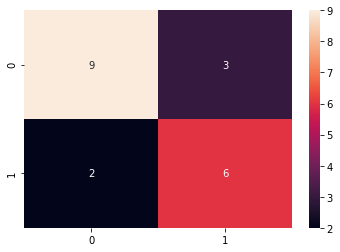

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x=df.iloc[:,:-1]
y = df.iloc[:,-1]

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.2)

RF_model = RandomForestClassifier(criterion='gini',random_state=42,n_jobs=-1,oob_score=True,n_estimators=50)
RF_model.fit(x_train,y_train)
y_pred = RF_model.predict(x_test)

print('Classification report :\n',classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_mat,annot=True)